In [77]:
import os
import sys
sys.path.append('/global/homes/e/emmayu/transients_cmuS24/timedomain/desitrip/py/') #Note:change this path as needed!
sys.path.append('/global/homes/e/emmayu/transients_cmuS24/timedomain/')

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras
from desitarget.sv1.sv1_targetmask import bgs_mask as bgs_mask_sv1
from desitarget.sv2.sv2_targetmask import bgs_mask as bgs_mask_sv2
from desitarget.sv3.sv3_targetmask import bgs_mask as bgs_mask_sv3

from desitrip.preproc import rebin_flux, rescale_flux
from desitrip.deltamag import delta_mag

from astropy.io import fits
from astropy.table import Table, vstack, hstack, join, unique
import fitsio

from glob import glob
from datetime import date

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras

mpl.rc('font', size=14)

from argparse import ArgumentParser

#DESITRIP_daily
from timedomain.sp_utils import *
from timedomain.filters import *
#from timedomain.iterators import *

import sqlite3

# Add redrock templates to look at residuals 

from scipy.ndimage import gaussian_filter1d
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution


import redrock.templates

templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/code/redrock-templates/0.8
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using redshift range 1.4000-6.9930 for rrtemplate-qso-HIZ.fits
DEBUG: Using redshift range 0.0500-1.5983 for rrtemplate-qso-LOZ.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## Prepare the CNN Model

In [78]:
  # ## Load the Keras Model
# 
# Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.


tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
# tfmodel = '/'.join([os.environ['HOME'], 'desi/timedomain/desitrip/docs/nb', '6label_cnn_restframe'])
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

if classifier is not None:
    classifier.summary()

label_names = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN']
label_names_arr=np.array(label_names)

#Only import tf and define stuff if you want to applt gradcam - otherwise save time
#This function needs to be changed if the keras model architecture is changed
gradcam = True
if gradcam:
    import tensorflow as tf
    last_conv_layer_name = "conv1d_23"
    classifier_layer_names = [
    "batch_normalization_23",
    "activation_23",
    "max_pooling1d_23",
    "flatten_5",
    "dense_5",
    "dropout_5",
    "Output_Classes"
    ]

    def make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    ):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer
        last_conv_layer = model.get_layer(last_conv_layer_name)
        last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

        # Second, we create a model that maps the activations of the last conv
        # layer to the final class predictions
        classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
        x = classifier_input
        for layer_name in classifier_layer_names:
            #print(layer_name,x.shape)
            x = model.get_layer(layer_name)(x)
        classifier_model = keras.Model(classifier_input, x)

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            last_conv_layer_output = last_conv_layer_model(img_array)
            tape.watch(last_conv_layer_output)
            # Compute class predictions
            preds = classifier_model(last_conv_layer_output)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:, top_pred_index]

        # This is the gradient of the top predicted class with regard to
        # the output feature map of the last conv layer
        grads = tape.gradient(top_class_channel, last_conv_layer_output)
        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
        #print(grads.shape,pooled_grads.shape)

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, i] *= pooled_grads[i]

        # The channel-wise mean of the resulting feature map
        # is our heatmap of class activation
        heatmap = np.mean(last_conv_layer_output, axis=-1)

        #We apply ReLU here and select only elements>0
        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        return heatmap

    preprocess_input = keras.applications.xception.preprocess_input
    decode_predictions = keras.applications.xception.decode_predictions
    classifier.summary

Model: "SNnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Spec (InputLayer)     [(None, 150, 1)]          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 150, 8)            48        
                                                                 
 batch_normalization_20 (Ba  (None, 150, 8)            32        
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 150, 8)            0         
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 75, 8)             0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 75, 16)            656   

## Prepare Files for Classification

In [79]:
def get_files(obsdate, tile_number, petal_id):
    # Access redux folder.
    #20210503 is when the directory structure changed, no more daily reductions in the tiles directory
    redux = '/'.join([os.environ['DESI_SPECTRO_REDUX'], 'daily'])
    if int(obsdate)<20210503:
        prefix_in = '/'.join([redux, 'tiles', tile_number, obsdate])
    else:
        prefix_in = '/'.join([redux, 'tiles/cumulative', tile_number, obsdate])

    if int(obsdate)<20210903:
        fiberstatus_key = 'FIBERSTATUS'
        ztable = 'ZBEST'
    else:
        fiberstatus_key = 'COADD_FIBERSTATUS'
        ztable = 'redshifts'
        
    if not os.path.isdir(prefix_in):
        print('{} does not exist.'.format(prefix_in))
        return [], []
    else:

        # Access the zbest and coadd files.
        # Files are organized by petal number.
        if int(obsdate)<20210503:
            zbfile = glob(f'{prefix_in}/zbest-{petal_id}*.fits')
            cafile = glob(f'{prefix_in}/coadd-{petal_id}*.fits')
            if len(cafile) == 0:
                cafile = glob(f'{zb_ca_dir}/spectra-{petal_id}*.fits.gz')
        elif int(obsdate)<20210903:
            #Only grabbing stuff from the most recent cumulative directory
            zb_ca_dir = glob(f'{prefix_in}/')[-1]
            zbfile = glob(f'{zb_ca_dir}/zbest-{petal_id}*.fits')
            cafile = glob(f'{zb_ca_dir}/spectra-{petal_id}*.fits')
            if len(cafile) == 0:
                cafile = glob(f'{zb_ca_dir}/spectra-{petal_id}*.fits.gz')
        else:
            zb_ca_dir = glob(f'{prefix_in}/')[-1]
            zbfile = glob(f'{zb_ca_dir}/redrock-{petal_id}*.fits')
            cafile = glob(f'{zb_ca_dir}/spectra-{petal_id}*.fits')
            if len(cafile) == 0:
                cafile = glob(f'{zb_ca_dir}/spectra-{petal_id}*.gz')
                    
    return zbfile, cafile

## Format the data for input to the CNN

In [80]:
import fitsio
def prepare_input(row_num):
    
    global allzbest, allfmap, allwave, allflux, allivar, allmask, allres
    
    row = transients[row_num]
    
    obsdate = row['desi_obs_date']
    obsdate = int(obsdate)
    tileid = row['desi_tileid']
    tileid = int(tileid)
    petalid = row['desi_petalid']
    petalid = int(petalid)
    target_id = int(row['desi_targetid'])
    
    zbfile, cafile = get_files(str(obsdate), str(tileid), str(petalid))

    if int(obsdate)<20210903:
            fiberstatus_key = 'FIBERSTATUS'
            ztable = 'ZBEST'
    else:
            fiberstatus_key = 'COADD_FIBERSTATUS'
            ztable = 'redshifts'
            
    if len(zbfile) < 1 or len(cafile) < 1:
        print('No files found for row #', row_num)
        return None
    
    zbfile = zbfile[0]
    cafile = cafile[0]
    
    # Access data from files
    if os.path.exists(zbfile):
            try:
                zbest = Table.read(zbfile, 'REDSHIFTS')
            except KeyError:
            # If 'REDSHIFTS' does not exist, try 'ZBEST' extension
                try:
                    zbest = Table.read(zbfile, 'ZBEST')
                    #print("Read data from 'ZBEST' extension.")
                except KeyError:
                    print("Neither 'REDSHIFTS' nor 'ZBEST' extensions exist in the FITS file.")
    if not os.path.exists(cafile):
        print('path does not exist for: ', cafile)
        return None
    pspectra = read_spectra(cafile)
    '''
    if int(obsdate)>20210503:
            select_nite = pspectra.fibermap['NIGHT'] == obsdate
            pspectra = pspectra[select_nite]
    '''
    cspectra = coadd_cameras(pspectra)
    cspectra.scores = None
    fibermap = cspectra.fibermap
    
    select = np.where(np.array(cspectra.fibermap['TARGETID']) == target_id)
   
    # Accumulate spectrum data.
    print(select)
    if (np.sum(select) > 0):
        print('made it to if statement')
        if allzbest == None:
            allzbest = zbest[select]
            allfmap = fibermap[select]
            allwave = cspectra.wave['brz']
            allflux = cspectra.flux['brz'][select]
            allivar = cspectra.ivar['brz'][select]
            allmask = cspectra.mask['brz'][select]
            allres  = cspectra.resolution_data['brz'][select]
            print('allzbest is none')
        else:
            allzbest = vstack([allzbest, zbest[select]])
            allfmap = vstack([allfmap, fibermap[select]])
            allflux = np.vstack([allflux, cspectra.flux['brz'][select]])
            allivar = np.vstack([allivar, cspectra.ivar['brz'][select]])
            allmask = np.vstack([allmask, cspectra.mask['brz'][select]])
            allres  = np.vstack([allres, cspectra.resolution_data['brz'][select]])
    #print(allzbest)

In [120]:
trans_file = '/global/homes/e/emmayu/transients_cmuS24/ToO_classification/too_transients.pkl'
transients_df = pd.read_pickle(trans_file).dropna().drop_duplicates(subset=['desi_targetid', 'desi_obs_date']).rename(columns={'desi_tiled':'desi_tileid'})
transients = Table.from_pandas(transients_df)


In [ ]:

from tqdm.notebook import tqdm
# We need to first vstack all the values 

allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None

fibererr = []
import warnings
for row in tqdm(range(len(transients))):
    prepare_input(row)

In [83]:

# Writing the first two variables as fits files
allzbest.write('allzbest.fits', format='fits', overwrite=True)
allfmap.write('allfmap.fits', format='fits', overwrite=True)

# Save the arrays to a .npz file
np.savez('cnn_arrays.npz', allwave=allwave,
         allflux=allflux, allivar=allivar, allmask=allmask, allres=allres)


In [85]:
from astropy.table import Table
# Load the fits files
allzbest_loaded = Table.read('allzbest.fits', format='fits')
allfmap_loaded = Table.read('allfmap.fits', format='fits')

# Load the arrays back from the .npz file
arrays = np.load('cnn_arrays.npz')

# Extract each array from the loaded file
allwave_loaded = arrays['allwave']
allflux_loaded = arrays['allflux']
allivar_loaded = arrays['allivar']
allmask_loaded = arrays['allmask']
allres_loaded = arrays['allres']

In [86]:
from astropy.table import Table, MaskedColumn
# Iterate through the rows
subtype_col = allzbest_loaded['SUBTYPE']
for i in range(len(subtype_col)):
    # Check if the value is a masked constant
    if isinstance(subtype_col[i], ma.core.MaskedConstant):
        # Replace the masked constant with an empty string
        subtype_col[i] = ''


In [87]:

allfmap = allfmap_loaded
allzbest = allzbest_loaded
allwave = allwave_loaded
allflux = allflux_loaded
allivar = allivar_loaded
allmask = allmask_loaded
allres = allres_loaded

if allzbest is None:
    print("No transient observations found")            
else  :
    # Apply the DESITRIP preprocessing to selected spectra.
    rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                        minwave=2500., maxwave=9500., nbins=150,
                                        log=True, clip=True)
    rsflux = rescale_flux(reflux)

In [88]:

pred = classifier.predict(rsflux)
ymax = np.max(pred, axis=1)

idx = np.argwhere((ymax > -1000)).flatten()
labels = np.argmax(pred, axis=1)
ntr = len(idx)
print(ntr,' transients found')


5/5 [==============================] - 0s 3ms/step
149  transients found


In [89]:
pred_selected = pred[idx]

In [90]:
 # Save data to file - we need to add ra dec, and some id
if ntr > 0:

    # Save classification info to a table.
    classification = Table()
    classification['TARGETID'] = allfmap[idx]['TARGETID']
    classification['CNNLABEL'] = label_names_arr[labels[idx]]
    classification['YMAX'] = ymax[idx]
    #classification['CNNPRED'] = pred[idx]
    classification['Galaxy_CNNPRED'] = pred_selected[:, 0]
    classification['SNIa_CNNPRED'] = pred_selected[:, 1]
    classification['SNIb_CNNPRED'] = pred_selected[:, 2]
    classification['SNIbc_CNNPRED'] = pred_selected[:, 3]
    classification['SNIc_CNNPRED'] = pred_selected[:, 4]
    classification['SNIIn_CNNPRED'] = pred_selected[:, 5]
    classification['SNIILP_CNNPRED'] = pred_selected[:, 6]
    classification['SNIIP_CNNPRED'] = pred_selected[:, 7]
    classification['KN_CNNPRED'] = pred_selected[:, 8]
    classification['Index'] = idx

In [95]:
all_classifications = join(classification, transients, keys_left='TARGETID', keys_right = 'desi_targetid')
mask = (allzbest['SUBTYPE']=='') & (allzbest['SPECTYPE']=='QSO')
allzbest[mask]
full_classifications_df = all_classifications.to_pandas().drop_duplicates(subset=['desi_targetid', 'desi_obs_date'])
full_classifications = Table.from_pandas(full_classifications_df)

In [119]:
# Extract the 'Z' column
z_column = allzbest['Z']
zwarn_column = allzbest['ZWARN']
full_classifications_df['desi_z'] = z_column
full_classifications_df['desi_zwarn'] = zwarn_column

full_classifications_df.to_csv('/global/homes/e/emmayu/transients_cmuS24/ToO_classification/too_transient_class.csv')
#full_classifications_df.sort_values(by='YMAX', ascending=False).columns

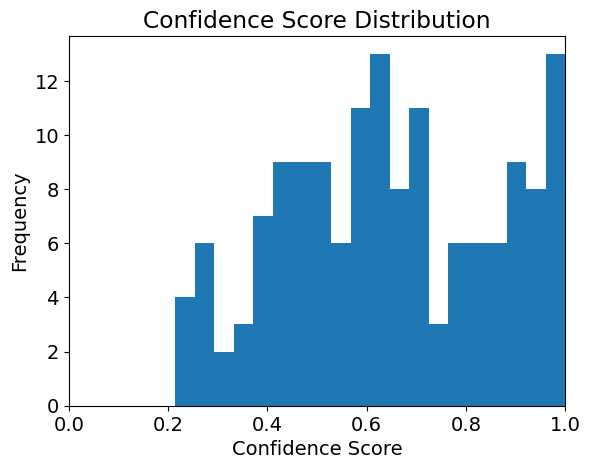

In [99]:
plt.hist(full_classifications_df['YMAX'], bins=20)
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.show()

In [100]:
fmap = hstack([allfmap[idx], allzbest[idx], classification])
#fmap['TARGETID_1'].name='TARGETID'
#fmap.remove_columns(['TARGETID_2','TARGETID_3']) 

# Pack data into Spectra and write to FITS.
cand_spectra = Spectra(bands=['brz'],
                       wave={'brz' : allwave},
                       flux={'brz' : allflux[idx]},
                       ivar={'brz' : allivar[idx]},
                       mask={'brz' : allmask[idx]},
                       resolution_data={'brz' : allres[idx]},
                       fibermap=fmap
                   )
out_path = '/global/homes/e/emmayu/transients_cmuS24/timedomain/cronjobs'
outfits = '{}/transient_candidate_spectra_{}_{}.fits'.format(out_path, 'lsdr_matches', '6_21_2024')
write_spectra(outfits, cand_spectra)
print('Output file saved in {}'.format(outfits))

R = Resolution(cand_spectra.resolution_data['brz'][0])

INFO:spectra.py:184:write_spectra: iotime 0.330 sec to write transient_candidate_spectra_lsdr_matches_6_21_2024.fits at 2024-07-18T13:44:29.925061


INFO:desiutil.log.dlm58.info:iotime 0.330 sec to write transient_candidate_spectra_lsdr_matches_6_21_2024.fits at 2024-07-18T13:44:29.925061


Output file saved in /global/homes/e/emmayu/transients_cmuS24/timedomain/cronjobs/transient_candidate_spectra_lsdr_matches_6_21_2024.fits


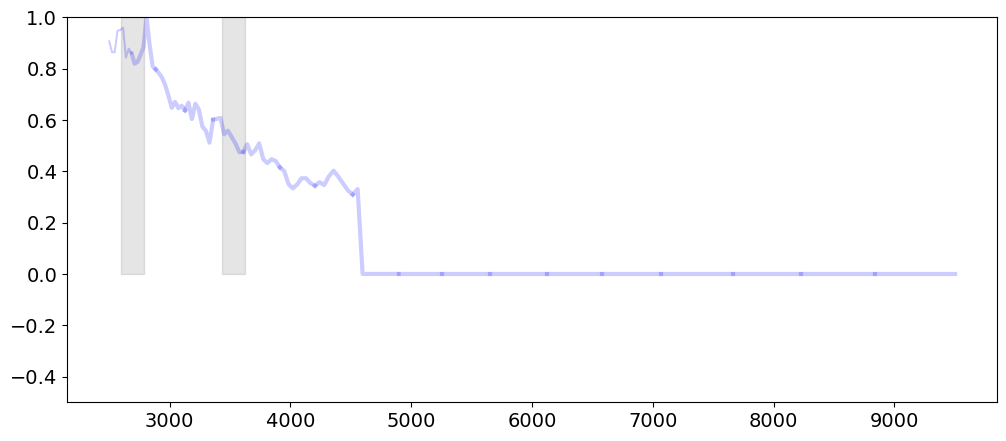

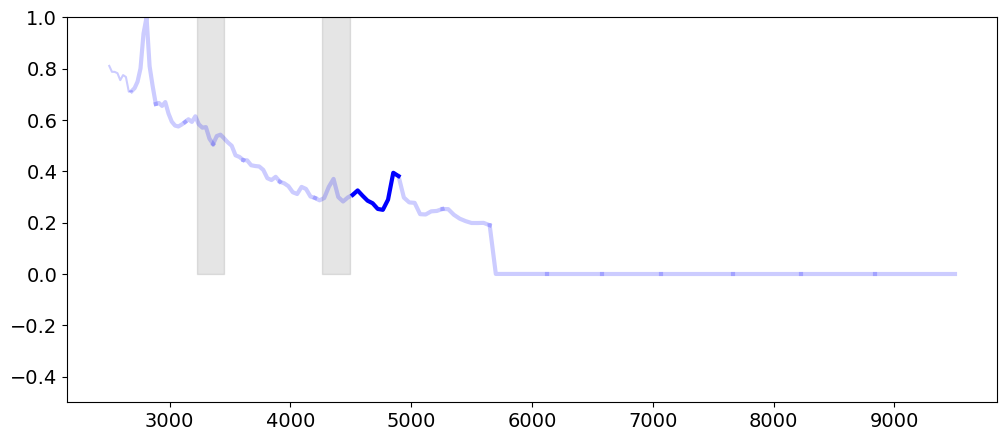

In [115]:
from IPython.display import clear_output

counter = 0

for row in full_classifications:
    plt.figure(figsize=(12,5))
    plt.ylim(-0.5,1)
    
    j = row['Index']
    obsdate = row['desi_obs_date']
    objid = row['TOOID']
    ymax = row['YMAX']
    cnnlabel = row['CNNLABEL']
    #these lines are to add to the output plot the wavelengths between the arms
    br_band=[5600,6000]
    rz_band=[7400,7800]

    #delta_fibermag_g=allfmap['DELTAMAG_G'][j]
    #delta_fibermag_r=allfmap['DELTAMAG_R'][j]
    #delta_fibermag_z=allfmap['DELTAMAG_Z'][j]

    #if ((type(delta_fibermag_g) == ma.core.MaskedConstant) | (type(delta_fibermag_r) == ma.core.MaskedConstant) | (type(delta_fibermag_z) == ma.core.MaskedConstant)):
        #continue

    if gradcam:
        this_flux=rsflux[j,:].reshape((1,150)) 

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            this_flux, classifier, last_conv_layer_name, classifier_layer_names
        )

        color='blue'

        #If a candidate has a deltamag>2 sigma away from the mean deltamag distribution
        #it's flagged as a deltamag candidate and we plot it in red
        rewave_nbin_inblock=rewave.shape[0]/float(heatmap.shape[0])
        first_bin=0
        for i in range(1,heatmap.shape[0]+1):
            alpha=np.min([1,heatmap[i-1]+0.2])
            last_bin=int(i*rewave_nbin_inblock)
            if (i==1):
                plt.plot(rewave[first_bin:last_bin+1], this_flux[0,first_bin:last_bin+1],c=color,alpha=alpha,\
                        label=str(allfmap['TARGETID'][j])+'\n'+label_names[labels[j]]+'\nz={:.2f}'.format(allzbest[j]['Z']))
            else:
                plt.plot(rewave[first_bin:last_bin+1], this_flux[0,first_bin:last_bin+1],c=color,alpha=alpha, linewidth=3,)
            first_bin=last_bin

    else:
        plt.plot(rewave, rsflux[j], alpha=0.7, linewidth=3, label='label: '+label_names[labels[j]]+'\nz={:.2f}'.format(allzbest[j]['Z']))


    this_br_band=br_band/(1.+(allzbest[j]['Z']))
    this_rz_band=rz_band/(1.+(allzbest[j]['Z']))  
    plt.fill_between(this_br_band,[0,0],[1,1],alpha=0.1,color='k')
    plt.fill_between(this_rz_band,[0,0],[1,1],alpha=0.1,color='k')                      
    

    spectype = allzbest['SPECTYPE'][j].strip()
    subtype = allzbest['SUBTYPE'][j].strip()
    fulltype = (spectype, subtype)
    try:
        ncoeff = templates[fulltype].flux.shape[0]
    except KeyError:
            print("Key Error for ", fulltype)
            continue
    coeff = allzbest['COEFF'][j][0:ncoeff]
    tflux = templates[fulltype].flux.T.dot(coeff)
    twave = templates[fulltype].wave * (1+allzbest[j]['Z'])
    txflux = R.dot(resample_flux(cand_spectra.wave['brz'], twave, tflux))
    res=allflux[j]-txflux
    res_smooth = gaussian_filter1d(res, 25)
    plt.plot(allwave/(1.+(allzbest[j]['Z'])), res_smooth, 'k-', alpha=0.3, linewidth=3,label='Residual')
    plt.title(f'{objid}, DESI Obsdate {obsdate}, {cnnlabel}, YMAX: {ymax:.3f}')
    plt.legend()

    plt.tight_layout()
    savepath = '/global/homes/e/emmayu/transients_cmuS24/ToO_classification/too_gradcam'
    outplot = '{}/transient_candidates_{}_{}.png'.format(savepath, allfmap['TARGETID'][j], obsdate)
    plt.savefig(outplot, dpi=150)
    plt.close()
    
    counter += 1
    print(f'Transients Plotted: {counter}/{len(full_classifications)}')
    clear_output(wait=True)
    #print('Figure saved in {}', outplot)
    #plt.clf()

In [117]:
allzbest

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,int32
43977350693867521,0.28824587029905596,6.60746352301806e-05,0,8917.690472211689,141.28582449414202 .. -29.34154743519525,7812,GALAXY,,10,95.36824505962431,--,--
43977356729470978,0.17281295017325335,3.8698695171877665e-05,0,7938.497233256698,155.3298489915231 .. 4.892903406988287,7809,GALAXY,,10,113.3472399264574,--,--
43977350698061833,0.0968074008446915,1.3482985309746452e-05,0,15243.908014945686,1315.1920692718702 .. 202.55114319986015,7778,GALAXY,,10,6509.560378707945,--,--
43977362765074455,0.09853505762649364,3.3576350788258616e-06,0,8350.944523096085,1036.5993219085672 .. -28.047727966807702,7755,GALAXY,,10,6476.231790304184,--,--
43977332633194522,0.2616688789624767,8.402755972406057e-06,0,8855.281312346458,467.55506383076795 .. 18.9998210290192,7840,GALAXY,,10,2454.620761781931,--,--
43977344679235612,0.06864487051728735,8.093698924683857e-06,0,8379.176302939653,696.1559088007537 .. -12.941566146888052,7776,GALAXY,,10,2053.5689573736163,--,--
43977356737859617,0.19986482405418582,2.8422007314936193e-05,0,8760.246003188193,1407.969212607949 .. 2.927919876436172,7769,GALAXY,,10,3491.994944445789,--,--
43977338660409380,0.06913632639453436,4.6096097075768816e-06,0,8418.581259995699,267.36963618366264 .. -55.07351842479846,7836,GALAXY,,10,2405.28785392642,--,--
39627676683600822,0.06768396555068229,5.15072460142053e-06,0,9499.267139971256,3902.592030528955 .. 107.27981783943338,7899,GALAXY,,10,5777.9420966506,--,--
